# A6 Customer Segmentation

**Rationale** The idea for this assignment is to give you hands on experience in applying behavioral segmentation techniques to real world data where the variables you use for segmentation are not already created for you (you must define them first). Thus you must first do "feature engineering" before you can do segmentation. Don't worry, this problem is broken down into components.

The dataset we use is a retail invoice. Each invoice is one purchase occassion, and for each invoice we have several observations representing the unique items (stockcode) purchased on that occassion.

The goal of the first part is to create useful features about each consumer's observed behaviors, i.e. go from transaction level to customer level data. The goal of the second part is to then do behavioral segmentation based on these newly constructed features.

# Part 1 Feature Engineering (25 points)

Generally, feature engineering is where your marketing domain knowledge comes into play. In other words, your intuitions about what matters in terms of separating consumers into different groups should drive what features (aka variables/columns) to create. However, in this assignment, you are expected to compute the characteristics detailed in the following instructions.


Read in the data, preview it, and familiarize yourself with the contents of the data.

In [115]:
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
drive.mount('drive', force_remount=True)

Mounted at drive


In [116]:
fpath = 'drive/MyDrive/Data Analytics/A6/' # change the path here
os.listdir(fpath)

['online_invoices.csv', 'Ryker Radley A6 Segmentation.ipynb']

In [117]:
# Read in the data (csv file)
df = pd.read_csv(fpath + 'online_invoices.csv', index_col = 0)

In [118]:
# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Answer questions here**

What does each row represent? **C**

A. 1 invoice (1 point of sale transaction) \\
B. A single item sold \\
**C. Each unique item sold in a transaction** \\
D. Daily sales \\
E. 1 customer's total purchases on each day



## Unique count variables

Create a dataframe, `df_u` that represents each consumer's total number of transactions and unique products purchased.

Hint: use a `groupby` + `.nunique()` statement. `df.groupby('id')[['var1', 'var2',....]].nunique().reset_index()` will compute the number of unique values of columns 'var1', 'var2',.... for each "id". You should calculate the number of unique `StockCode`'s (like SKU's) and `InvoicesNo`'s for each `CustomerID`. Change your column names in the resulting dataframe, `df_u`, to `['CustomerID', 'NProducts', 'NTrans']`.

In [119]:
# use a groupby operation with the nunique summary function to calculate the number of unique
#transactions and product SKU's for each item
# call the resulting dataframe df_u
df_u = df.groupby('CustomerID')[['InvoiceNo','StockCode']].nunique().reset_index()

In [120]:
# rename the columns for unique transactions and products purchased to:
# NTrans and NProducts, respectively
# Remember, you can either use the syntax dataframe.columns = ['col1', 'col2',....] <- set all the column names using list of strings for each column
# or you can use dataframe.rename(columns = {'oldcolname':'newcolname', 'oldcolname2':'newcolname2', ....}, inplace = True) <- rename only the ones that should be renamed
df_u.columns = ['CustomerID','NTrans','NProducts']

In [121]:
# take a look at the first 5 rows of resulting dataframe, make sure contents are what you expect
df_u.head()


,CustomerID,NTrans,NProducts
0,12346.0,1,1
1,12347.0,7,103
2,12348.0,4,21
3,12349.0,1,72
4,12350.0,1,16



## Customer spend

Compute the total customer spending and number of units purchased for each customer of this retailer.

Hint
1. Create a column for `TotalSpend` (unit price x quantity)
1. Use a (groupby + sum) to create a dataframe `df_s` that contains each customer's sum of `TotalSpend` and `Quantity`
1. rename the quantity column to `TotalUnits`


In [122]:
# create total spend column

In [123]:
# create dataframe, df_s, that contains the total spend and quantity for each customer using groupby statement
# remember to reset_index
df_s = df
df_s['Total Spent'] = df.Quantity * df.UnitPrice
df_s = df_s.groupby('CustomerID')[['Total Spent','Quantity']].sum().reset_index()

In [124]:
# rename columns so that resulting dataframe has columns: CustomerID, TotalSpend, and TotalUnits
df_s.columns = ['CustomerID','TotalSpend','TotalUnits']

In [125]:
# take a look at the first 5 rows of resulting dataframe, make sure contents are what you expect
df_s.head()


,CustomerID,TotalSpend,TotalUnits
0,12346.0,77183.60,74215
1,12347.0,4310.00,2458
2,12348.0,1437.24,2332
3,12349.0,1457.55,630
4,12350.0,294.40,196



## Compute price of average SKU purchased

Compute and create the `AveragePrice` column using the `df_s` dataframe's `TotalSpend` and `TotalUnits`.


In [126]:
# create average price column in df_s
df_s['AveragePrice'] = (df_s.TotalSpend / df_s.TotalUnits)


In [127]:
# preview df_s to make sure average price is as expected
df_s.head()


,CustomerID,TotalSpend,TotalUnits,AveragePrice
0,12346.0,77183.60,74215,1.040000
1,12347.0,4310.00,2458,1.753458
2,12348.0,1437.24,2332,0.616312
3,12349.0,1457.55,630,2.313571
4,12350.0,294.40,196,1.502041



## Merge `df_u` and `df_s`, call new dataframe df_c (c for "consumer")

Using the variables in `df_c`, compute the following additional column:
1. Spend per transaction (call it "SpendPerTrans")

In total, you should have `df_c` with columns `['CustomerID', 'NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans']`


**Answer this**

On what column should you merge `df_s` and `df_u`?

* Answer: **CustomerID**

In [128]:
# do the merge (review notes from module 3 on merges if necessary)
# use an outer merge (e.g. how='outer'), call resulting dataframe, df_c
df_c = pd.merge(df_s,df_u,how='outer',on='CustomerID')


In [129]:
# create the column 'SpendPerTrans'
df_c['SpendPerTrans'] = df_c.TotalSpend / df_c.NTrans


In [130]:
# preview df_c to make sure it looks as expected
df_c.head()


,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans
0,12346.0,77183.60,74215,1.040000,1,1,77183.600000
1,12347.0,4310.00,2458,1.753458,7,103,615.714286
2,12348.0,1437.24,2332,0.616312,4,21,359.310000
3,12349.0,1457.55,630,2.313571,1,72,1457.550000
4,12350.0,294.40,196,1.502041,1,16,294.400000


## Log transformation

1. Plot the histogram of all the variables of df_c other than CustomerID
1. Replace each of these variables with their respective log transformations
1. Plot the histograms again, what's different?

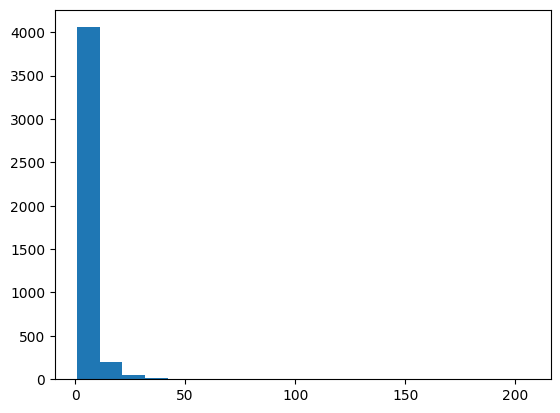

In [131]:
# plot the histogram of NTrans
plt.hist(df_c.NTrans,bins=20)
plt.show()

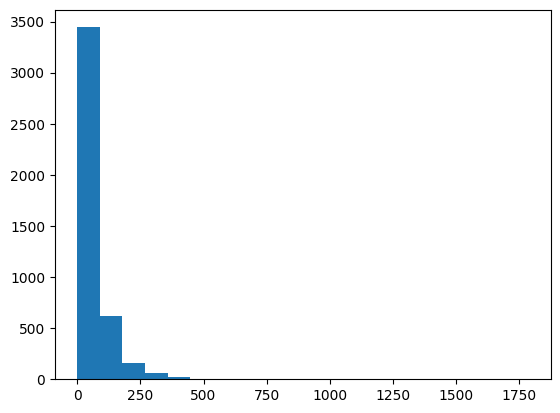

In [132]:
# plot the histogram of NProducts
plt.hist(df_c.NProducts,bins=20)
plt.show()


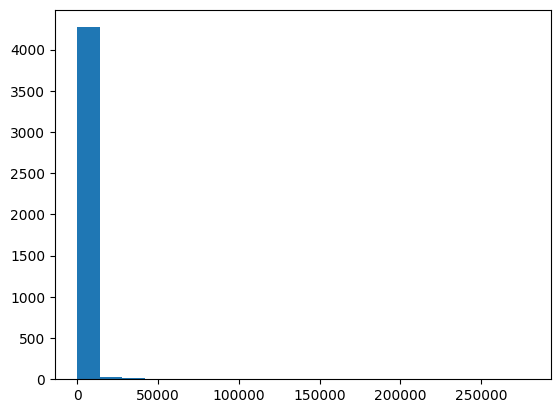

In [133]:
# plot the histogram of TotalSpend
plt.hist(df_c.TotalSpend,bins=20)
plt.show()


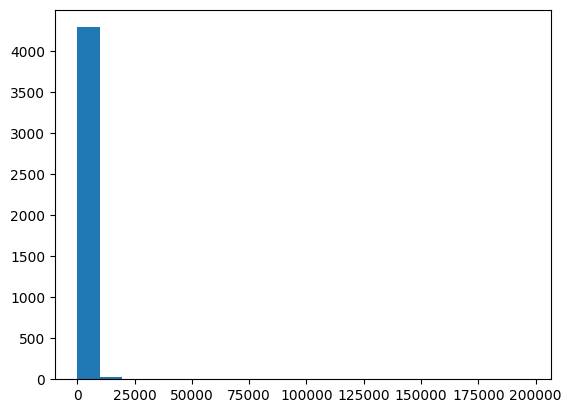

In [134]:
# plot the histogram of TotalUnits
plt.hist(df_c.TotalUnits,bins=20)
plt.show()


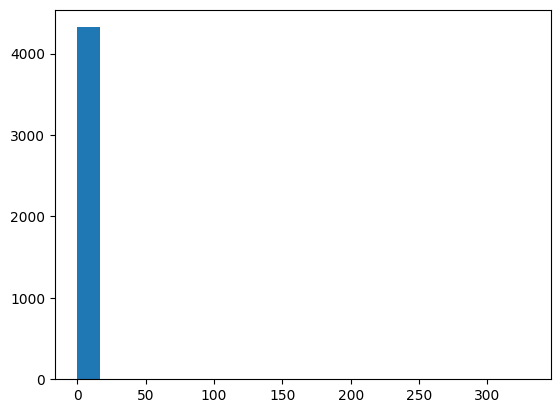

In [135]:
# plot the histogram of AveragePrice
plt.hist(df_c.AveragePrice,bins=20)
plt.show()


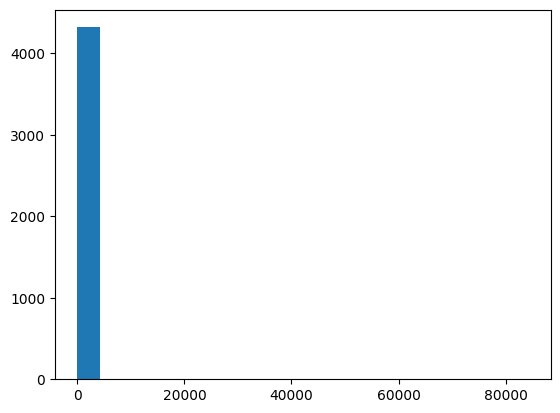

In [136]:
# plot the histogram of SpendPerTrans
plt.hist(df_c.SpendPerTrans,bins=20)
plt.show()


In [137]:
# Write a loop through all variables of df_c other than CustomerID
# to replace each column with its log.
# You can start the loop using: for c in df_c.columns[1:]:
# (since df_c.columns[0] is the CustomerID column).
# For some column, c, you can replace the column with its log using:
# dataframe[c] = np.log(dataframe[c])
# (of course, use the right variable name for your dataframe)


for c in df_c.columns[1:]:
  df_c[c] = np.log(df_c[c])
df_c.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans
0,12346.0,11.253942,11.214722,0.039221,0.000000,0.000000,11.253942
1,12347.0,8.368693,7.807103,0.561590,1.945910,4.634729,6.422783
2,12348.0,7.270480,7.754482,-0.484002,1.386294,3.044522,5.884186
3,12349.0,7.284512,6.445720,0.838792,0.000000,4.276666,7.284512
4,12350.0,5.684939,5.278115,0.406825,0.000000,2.772589,5.684939


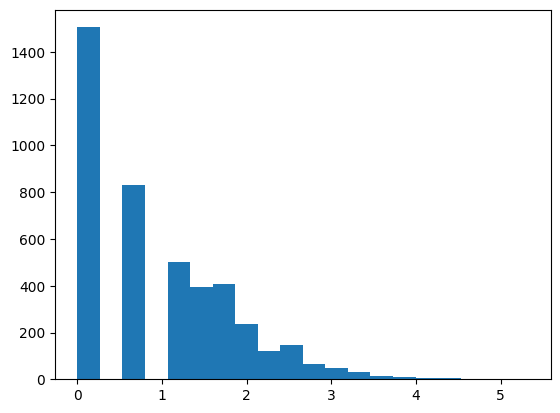

In [138]:
# plot the histogram of NTrans (after taking the log in cell above)
plt.hist(df_c.NTrans,bins=20)
plt.show()


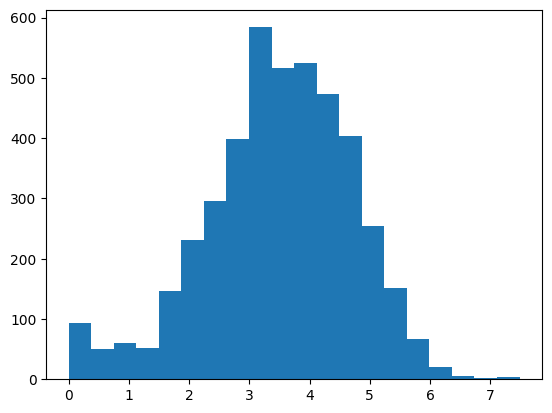

In [139]:
# plot the histogram of NProducts (after taking the log)
plt.hist(df_c.NProducts,bins=20)
plt.show()


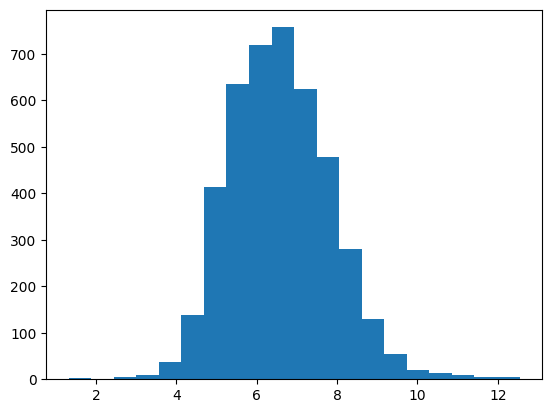

In [140]:
# plot the histogram of TotalSpend (after taking the log)
plt.hist(df_c.TotalSpend,bins=20)
plt.show()


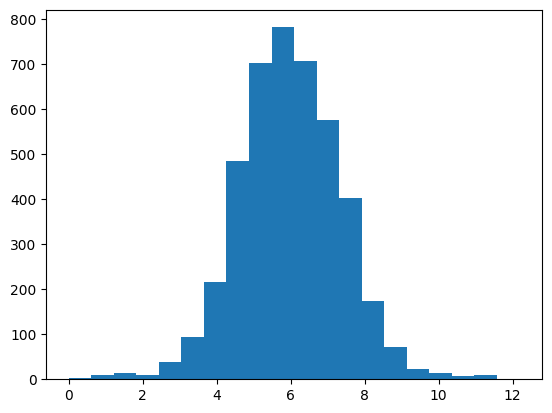

In [141]:
# plot the histogram of TotalUnits (after taking the log)
plt.hist(df_c.TotalUnits,bins=20)
plt.show()


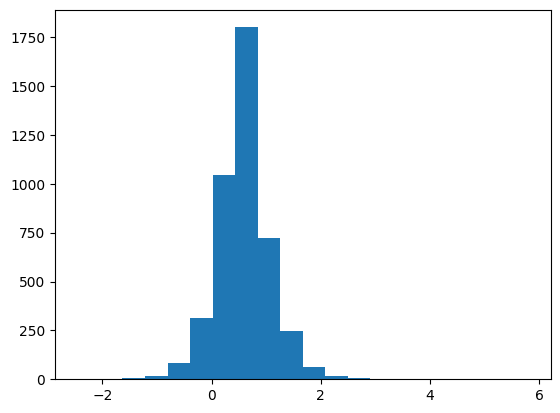

In [142]:
# plot the histogram of AveragePrice (after taking the log)
plt.hist(df_c.AveragePrice,bins=20)
plt.show()


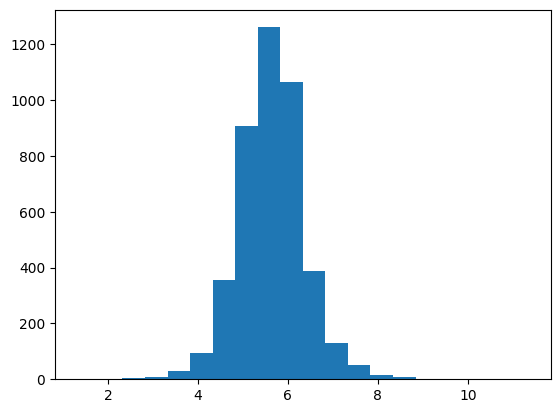

In [143]:
# plot the histogram of SpendPerTrans (after taking the log)
plt.hist(df_c.SpendPerTrans,bins=20)
plt.show()


**Answer this**

Why might you want to transform these variables by taking logs of each of these variables? (Notice the difference after taking the log transformation)

* Answer: **Taking the log allows us to show the distribution of the data more accurately because it better accounts for outliers and the wide range of the data set.**

# Create standaradized version of df_c

1. Create `df_c_std` that has all the columns of `df_c` except `CustomerID`.
1. Write a loop through all the columns of `df_c_std` to standardize each column (compute the z-score by subtracting mean and dividing by standard deviation).


In [144]:
# First, create df_c_std by selecting all columns from df_c except CustomerID
df_c_std = df_c.drop(columns = 'CustomerID')
mean = df_c_std.mean()
std = df_c_std.std()

In [145]:
# write a loop to standardize each column of df_c_std
# by replacing each column with (that column - the mean of the column) / std of column
for c in df_c_std.columns:
  df_c_std[c] = (df_c_std[c] - mean[c])/std[c]


In [146]:
# preview df_c_std to make sure the values have been standardized
df_c_std.head()

,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans
0,3.718600,3.807404,-1.070471,-1.043705,-2.861400,7.516677
1,1.424214,1.327975,-0.065642,1.119085,0.943194,1.049633
2,0.550901,1.289687,-2.076942,0.497097,-0.362188,0.328660
3,0.562060,0.337414,0.467585,-1.043705,0.649264,2.203153
4,-0.709940,-0.512151,-0.363348,-1.043705,-0.585415,0.061947


**Answer question**

Why is it important to standardize variables before performing clustering?

* Answer: **Standardizing variables allows us to show the distance between different clusters/observations in the data set. It also allows us to directly compare differing data sets since each data set is standardized.**

# Part 2 Segmentation (25 points)



## Dimensionality reduction

1. Compute the 2D principal components transformation of `df_c_std`, call this `transformed`
1. Make sure `transformed` is a dataframe, then name the columns 'pc1' and 'pc2' for principal component 1 and 2, respectively.
1. Add `pc1` and `pc2` to the df_c dataframe (create the same 2 columns in df_c).

Create a scatter plot of the principal components 1 vs 2.


**Answer question**

Why might you want to reduce the dimensionality of your data (using PCA) before performing clustering?

* Answer: **Reducing the dimensionality of the data to fewer dimensions allows easier visualization and helps the individual grasp the structure/relationships in the data more thoroughly.**

In [147]:
# Use PCA to reduce df_c_std to its first 2 principle components
# store the result as 2 columns in the *df_c* dataframe:
# 'pc1' and 'pc2'
pca = PCA(n_components=2)
transformed = pca.fit_transform(df_c_std)
transformed = pd.DataFrame(data=transformed, columns=['pc1','pc2'])
for c in transformed:
  df_c[c] = transformed[c]


In [148]:
# take a look at df_c to make sure principle components are in the dataframe
df_c.head()


,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans,pc1,pc2
0,12346.0,11.253942,11.214722,0.039221,0.000000,0.000000,11.253942,4.916838,0.740811
1,12347.0,8.368693,7.807103,0.561590,1.945910,4.634729,6.422783,2.632158,0.281418
2,12348.0,7.270480,7.754482,-0.484002,1.386294,3.044522,5.884186,1.343655,-1.924887
3,12349.0,7.284512,6.445720,0.838792,0.000000,4.276666,7.284512,1.007478,0.852119
4,12350.0,5.684939,5.278115,0.406825,0.000000,2.772589,5.684939,-1.237310,-0.447156


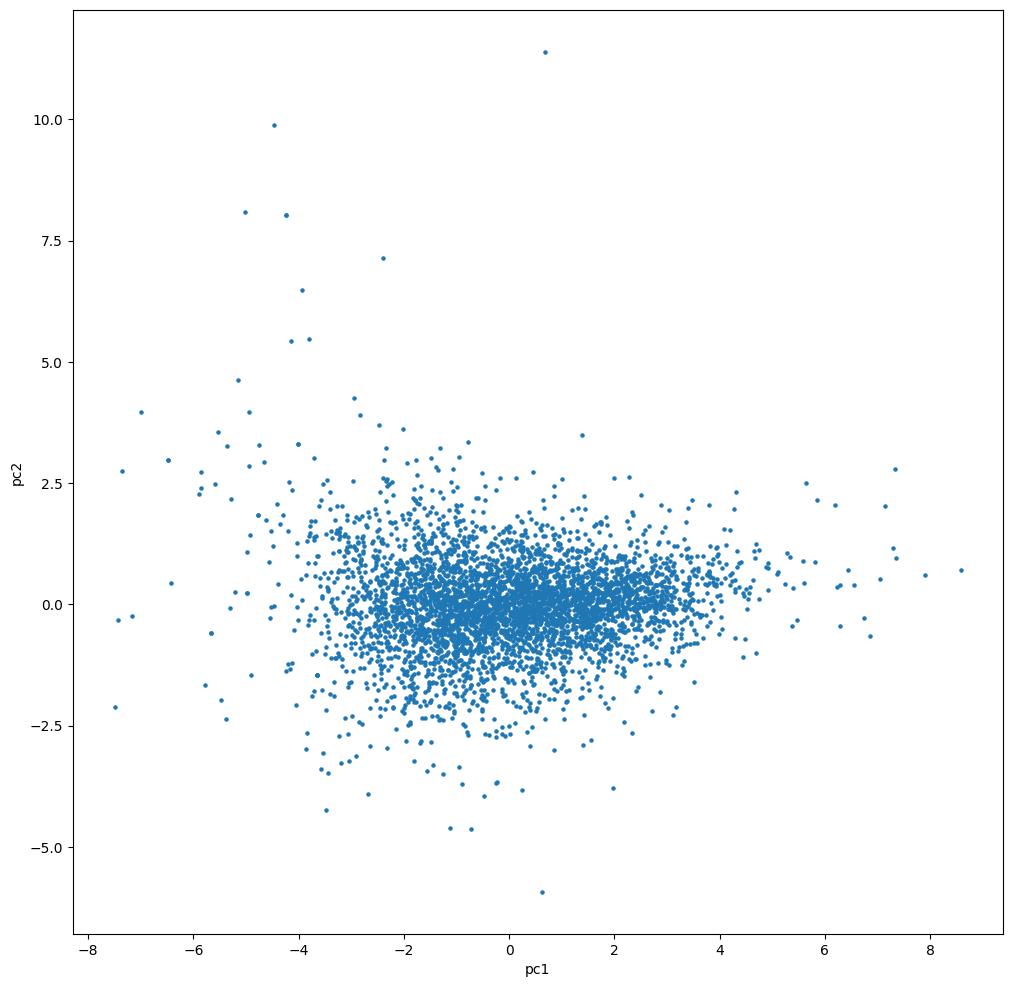

In [149]:
# Create a scatterplot of pc1 vs pc2
df_c.plot(x='pc1',y='pc2',kind='scatter',figsize=(12,12),marker='.')
plt.show()


## Segmentation
Using a loop, compute the k-means clustering for $k$ from 2 to 10 segments using the `transformed` dataframe. Store the segment as the column `'seg2'`,`'seg3'`,...,`'seg10'` in the `df_c` dataframe. Make sure you store the inertia metrics in a list called `elbowdata` like in the notes. Create the elbow plot for your k-means clustering.

1. How many segments does there appear to be based on the elbow plot?
1. Use a loop to plot pc1 vs pc2 for each segment (different color for each segment)
1. Use a groupby statement to show the mean of the variables in the raw versions (not z-scores) used to conduct the segmentation. e.g. what are the averages of `['NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans']`

1. In a few sentences, describe what are the characteristics of the resulting segments. Any distinctive segments?

**Hints**
1. Note here that `k` should be the number of clusters at each iteration of your loop, e.g. `for k in ....`
2. `df_c['seg{}'.format(k)]=` your k-means segmentation to create the `'seg2'`, ..., `'seg15'` columns.

In [150]:
# Write a loop to perform k-means segmentation
# on the principal component columns, e.g. pc1 and pc2, in *df_c*
# for k from 2 to 10, e.g. for k in range(2,11):
# Be sure to save the inertia metric to create the elbowplot
# see similar example in notes
elbowdata = list()
for k in range(2,11):
  clusterer = KMeans(n_clusters=k) # Do kmeans
  df_c['seg_{}'.format(k)] = clusterer.fit_predict(df_c[['pc1','pc2']]) # store cluster segment
  inertia = clusterer.inertia_ # within sum variances is aka inertia
  elbowdata.append([k, inertia]) # append to elbowdata
elbowdata = pd.DataFrame(elbowdata, columns = ['k', 'inertia'])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [151]:
# preview your dataframe df_c to get an idea of the contents
df_c.head()


,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans,pc1,pc2,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,seg_9,seg_10
0,12346.0,11.253942,11.214722,0.039221,0.000000,0.000000,11.253942,4.916838,0.740811,1,1,3,1,3,2,0,1,7
1,12347.0,8.368693,7.807103,0.561590,1.945910,4.634729,6.422783,2.632158,0.281418,1,1,3,1,3,4,2,3,2
2,12348.0,7.270480,7.754482,-0.484002,1.386294,3.044522,5.884186,1.343655,-1.924887,1,2,1,0,2,5,7,8,8
3,12349.0,7.284512,6.445720,0.838792,0.000000,4.276666,7.284512,1.007478,0.852119,1,2,1,0,0,0,5,2,0
4,12350.0,5.684939,5.278115,0.406825,0.000000,2.772589,5.684939,-1.237310,-0.447156,0,0,2,3,1,6,1,0,6


**Answer this**
What does each of the segk (for k =1,...,10) columns represent?

1. Answer: **Each column represents the different number of segments that the data frame is split up into. In other words, seg_2 has all of the data split into two segments while seg_10 has the data split into 10 segments.**

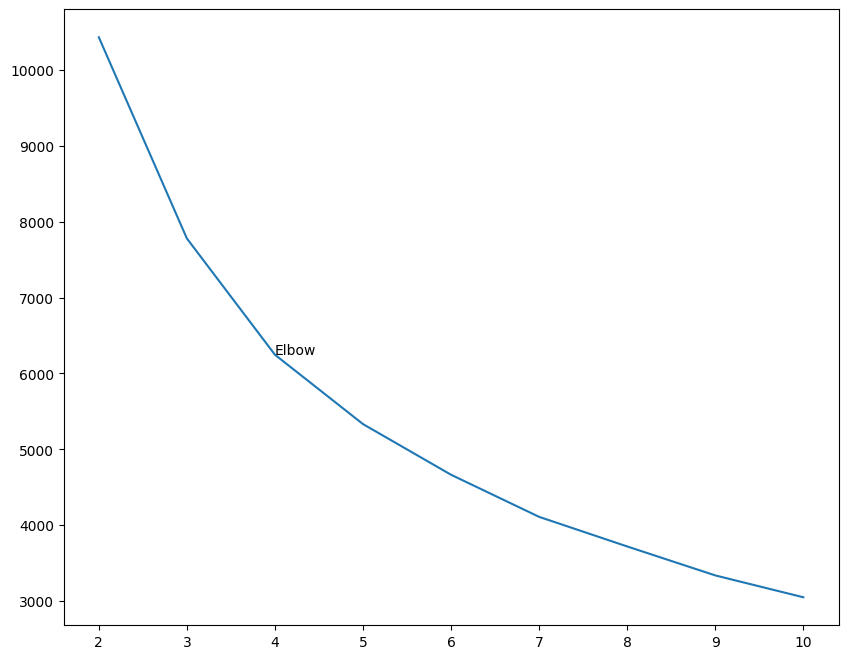

In [152]:
# Create the elbow plot
fig, ax = plt.subplots(1, figsize = (10, 8))
ax.plot(elbowdata.k, elbowdata.inertia)
ax.annotate( 'Elbow', (elbowdata.loc[2, 'k'],elbowdata.loc[2, 'inertia']))
plt.show()

**Answer this**
Based on the eyeball test, where is the "elbow"? i.e. how many clusters seems the "right" number
1. Answer: **Around 4 clusters**

## Inspect segments

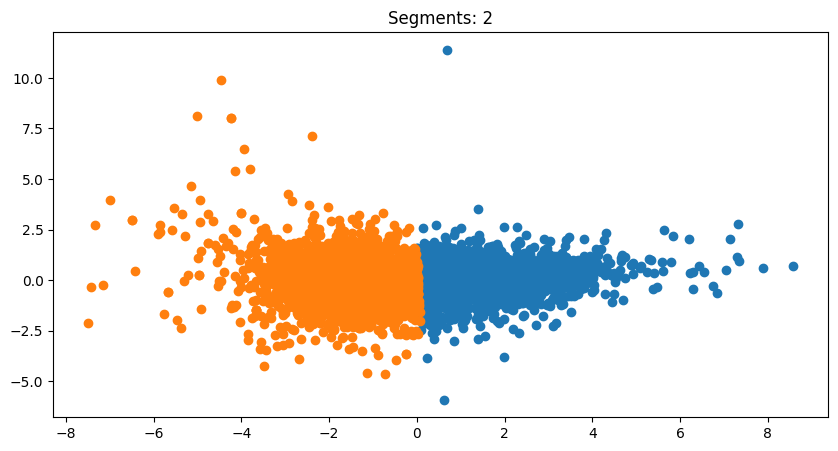

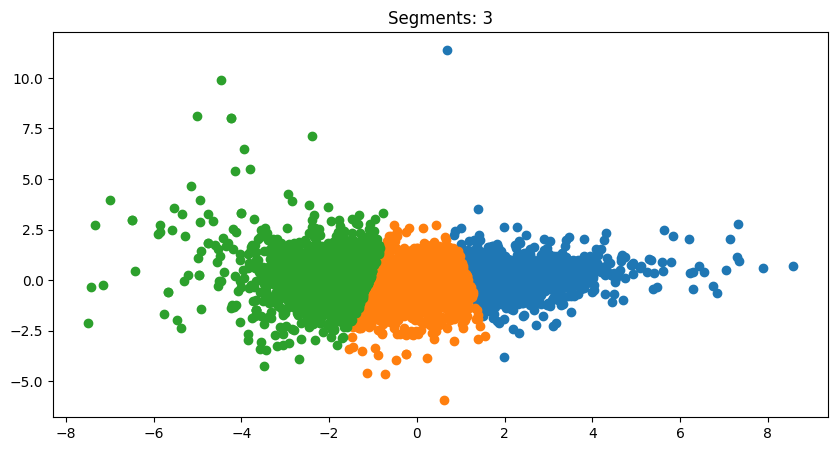

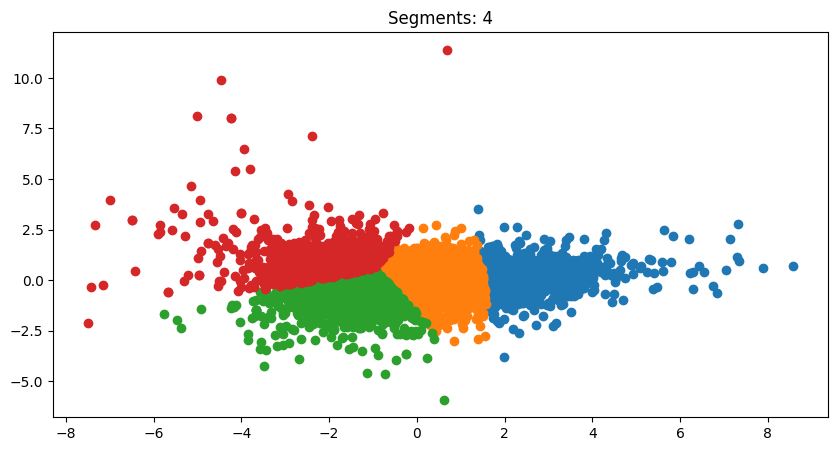

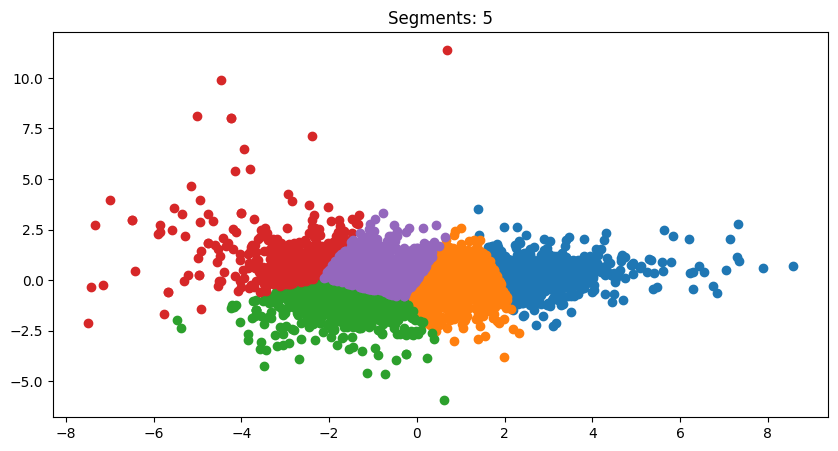

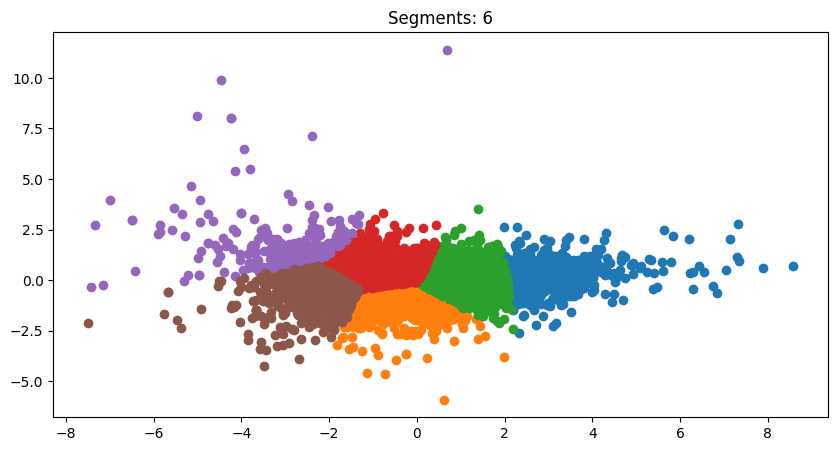

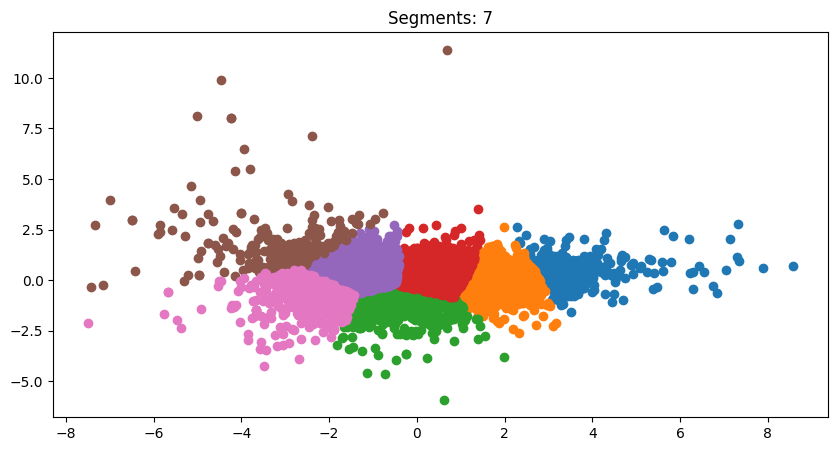

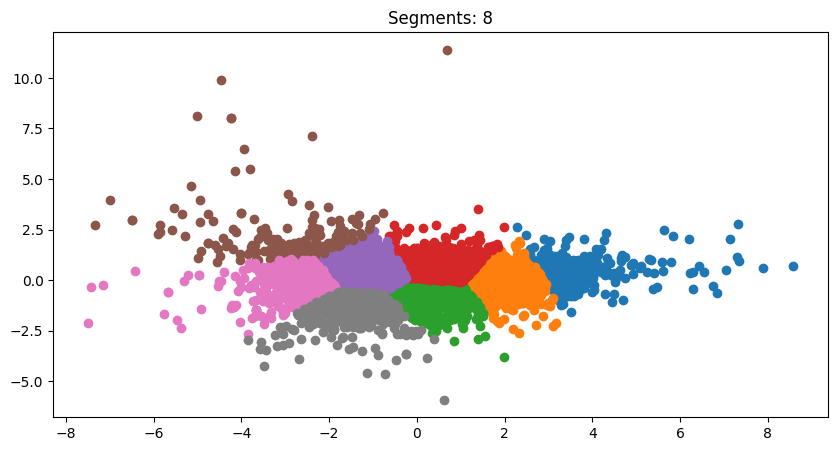

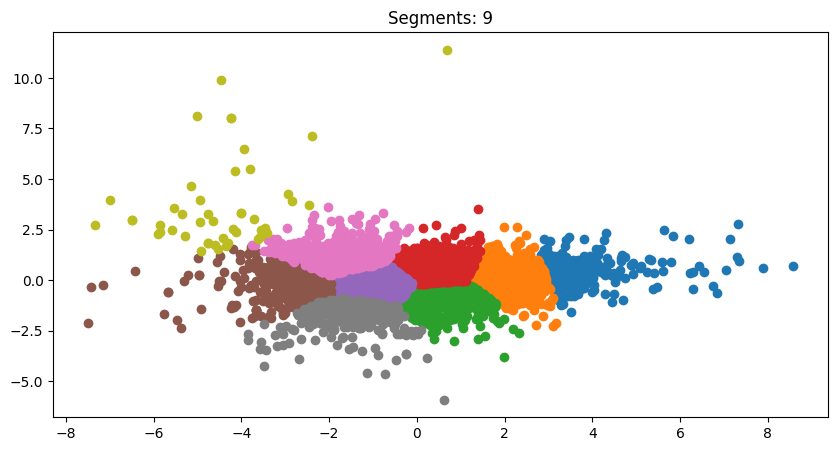

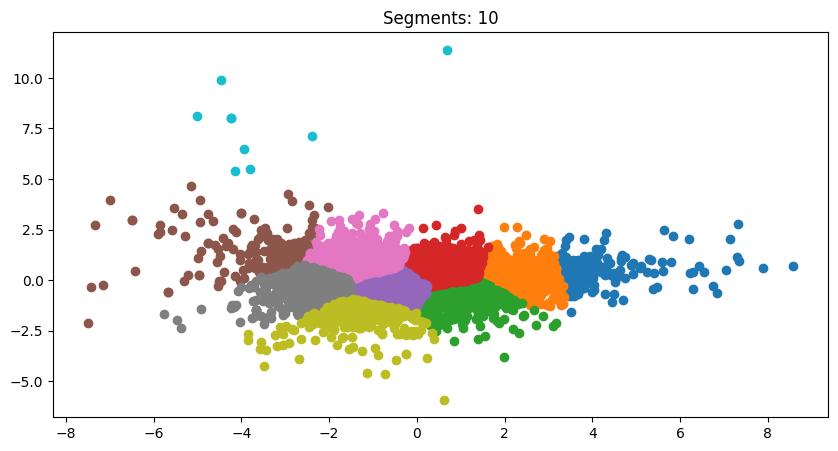

In [153]:
# Write a loop through each of the segments in your optimal KMeans cluster
# and plot pc1 vs pc2 for that segment
# similar to plotting price vs demand for each region of avocados dataset
# use dot size 1
# e.g.
#for s in df_c['Segk']:
#  temp = df_c[df_c['Segk'] == s]
#  plt.scatter(temp.pc1, temp.pc2, s = 1)
# where segk is whichever KMeans result you deemed optimal based on previous elbow plot
for S in range(2,11):
    plt.figure(figsize = (10,5))
    plt.title('Segments: {}'.format(S))
    for c in df_c['seg_{}'.format(S)].unique():
        temp = df_c[df_c['seg_{}'.format(S)]==c]
        plt.scatter(temp.pc1, temp.pc2)



Compute the average of:
```
NTrans	NProducts	TotalSpend	TotalUnits	AveragePrice SpendPerTrans
```
For each segment of the optimal KMeans segmentation (optimal being the k you found above in elbow plot).

Since these variables in df_c have been log-transformed, use np.exp(the appropriate groupby + mean statement) to take the exponent of the resulting means, i.e. "undo" the log-transformation.

e.g. np.exp(df.groupby('grpvar')[['var1', 'var2','var3',...,etc.]].mean())

In [154]:
# segment averages
np.exp(df_c.groupby('seg_4')[['NTrans','NProducts','TotalSpend','TotalUnits','AveragePrice','SpendPerTrans']].mean())


,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
seg_4,,,,,,
0,1.269684,8.617724,219.328817,60.158621,3.645842,172.742845
1,2.734223,44.862125,907.846097,513.292912,1.768671,332.030767
2,1.295202,14.868599,230.775668,175.328995,1.316244,178.177293
3,8.091331,116.266436,4017.765922,2378.571543,1.689151,496.551913


**Answer questions below**
1. Which segment buys the most expensive items?
    * Answer: **Segment 1**
1. Which segment spends the most?
    * Answer: **Segment 4**
1. Which segment buys the most variety of products?
    * Answer: **Segment 4**
1. Which segment buys the  least variety of products?
    * Answer: **Segment 1**
1. Are there any segments that seem like they should be combined?
    * Answer: **No, the segments are different enough to leave them alone.**
1. Suppose you want to run some promotions that will get customers to spend more. Pick 2 of the segments that are very different and describe a hypothetical promotional campaign targeted at each (e.g. could be some kind discount with a min. spend qualification, or maybe some kind of a volume discount, etc. - be creative). Explain why each campaign might be a better fit for the targeted segment.
    * Answer: **Segment 1 and Segment 4 are very different. Segment 4 seems to have the most transations, but spends less per product. Compare this to segment 1, this segment purchases expensive items while not having as many transactions. This means that for segment 4 we should heavily push coupon books, rewards cards, and store benefits that are better for consistent buyers. For segment 1, we may instead push deals on expensive items, discounts on luxury goods, and/or target marketing for pricey products.**